In [1]:
# Install the required libraries
!pip install torch
!pip install transformers
!pip install pyspellchecker

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import csv

# Define the GPT-2 model and tokenizer
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # Set pad_token to eos_token


# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define a custom dataset to load sonnets from a CSV file
class SonnetDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=128):
        self.sonnets = self.load_sonnets(csv_file)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def load_sonnets(self, csv_file):
        sonnets = []
        with open(csv_file, 'r', encoding='utf-8') as file:
            reader = csv.reader(file)
            for row in reader:
                sonnet = row[0].strip()  # Assuming sonnet is in the first column
                if sonnet:
                    sonnets.append(sonnet)
        return sonnets

    def __len__(self):
        return len(self.sonnets)

    def __getitem__(self, idx):
        sonnet = self.sonnets[idx]
        encoding = self.tokenizer(sonnet, return_tensors="pt", truncation=True, max_length=self.max_length, padding="max_length")
        return {key: encoding[key][0] for key in encoding}

# Set up your dataset and DataLoader
csv_file_path = "shakespeare_sonnets.csv"  # Adjust the path to your sonnet dataset
sonnet_dataset = SonnetDataset(csv_file_path, tokenizer)
train_loader = DataLoader(sonnet_dataset, batch_size=8, shuffle=True)

# Set up training parameters
num_epochs = 15
learning_rate = 5e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

# Training loop
model.train()
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    for batch in tqdm(train_loader, desc="Training"):
        inputs = {key: batch[key].to(device) for key in batch}
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    scheduler.step()

# Save the trained model
output_model_path = "finetuned_model"
model.save_pretrained(output_model_path)
tokenizer.save_pretrained(output_model_path)

Epoch 1/15


Training: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


Epoch 2/15


Training: 100%|██████████| 20/20 [00:01<00:00, 14.53it/s]


Epoch 3/15


Training: 100%|██████████| 20/20 [00:01<00:00, 14.51it/s]


Epoch 4/15


Training: 100%|██████████| 20/20 [00:01<00:00, 14.54it/s]


Epoch 5/15


Training: 100%|██████████| 20/20 [00:01<00:00, 14.52it/s]


Epoch 6/15


Training: 100%|██████████| 20/20 [00:01<00:00, 14.51it/s]


Epoch 7/15


Training: 100%|██████████| 20/20 [00:01<00:00, 14.55it/s]


Epoch 8/15


Training: 100%|██████████| 20/20 [00:01<00:00, 14.56it/s]


Epoch 9/15


Training: 100%|██████████| 20/20 [00:01<00:00, 14.56it/s]


Epoch 10/15


Training: 100%|██████████| 20/20 [00:01<00:00, 14.55it/s]


Epoch 11/15


Training: 100%|██████████| 20/20 [00:01<00:00, 14.55it/s]


Epoch 12/15


Training: 100%|██████████| 20/20 [00:01<00:00, 14.55it/s]


Epoch 13/15


Training: 100%|██████████| 20/20 [00:01<00:00, 14.56it/s]


Epoch 14/15


Training: 100%|██████████| 20/20 [00:01<00:00, 14.55it/s]


Epoch 15/15


Training: 100%|██████████| 20/20 [00:01<00:00, 14.53it/s]


('finetuned_model/tokenizer_config.json',
 'finetuned_model/special_tokens_map.json',
 'finetuned_model/vocab.json',
 'finetuned_model/merges.txt',
 'finetuned_model/added_tokens.json')

In [3]:
# Generate a sonnet using the fine-tuned model with TextGenerationConfig
config = GPT2Config.from_pretrained(output_model_path)
config.max_length = 200  # 14 lines with 10 syllables each
config.num_return_sequences = 1  # Number of sequences to generate
model = GPT2LMHeadModel.from_pretrained(output_model_path, config=config)
model.to(device)  # Move the model back to the device

import syllables

def post_process_sonnet(generated_sonnet):
    # Split the text into lines based on syllable count (10 syllables per line)
    syllables_per_line = 10
    words = generated_sonnet.split()
    lines = [" ".join(words[i:i+syllables_per_line]) for i in range(0, len(words), syllables_per_line)]

    # Capitalize the first word of each line
    lines = [line.capitalize() for line in lines]

    # Ensure each line has exactly 10 syllables
    for i, line in enumerate(lines):
        current_syllables = sum(syllables.estimate(word) for word in line.split())
        if current_syllables > syllables_per_line:
            # Truncate words if the line has more than 10 syllables
            words_in_line = line.split()
            while current_syllables > syllables_per_line:
                # Remove the last word until the line has exactly 10 syllables
                last_word = words_in_line.pop()
                current_syllables -= syllables.estimate(last_word)
            lines[i] = " ".join(words_in_line)
        elif current_syllables < syllables_per_line:
            # Pad words if the line has fewer than 10 syllables
            lines[i] = line + " " + " ".join(["<PAD>" for _ in range(syllables_per_line - current_syllables)])

    # Filter out unwanted characters and remove empty lines
    allowed_characters = set("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ',.?! ")
    lines = ["".join(c for c in line if c in allowed_characters) for line in lines]
    lines = [line for line in lines if line]  # Remove empty lines

    # Ensure the sonnet has exactly 14 lines
    while len(lines) < 14:
        lines.append(" ".join(["<PAD>" for _ in range(syllables_per_line)]))

    formatted_sonnet_q1 = "\n".join(lines[:4])
    formatted_sonnet_q2 = "\n".join(lines[4:8])
    formatted_sonnet_q3 = "\n".join(lines[8:12])
    formatted_sonnet_c = "\n".join(lines[12:14])
    formatted_sonnet = [formatted_sonnet_q1, 
                        formatted_sonnet_q2, 
                        formatted_sonnet_q3, 
                        formatted_sonnet_c]
    
    # Join the lines to form the sonnet
    formatted_sonnet = "\n\n".join(formatted_sonnet)

    # Remove any remaining <PAD> tokens
    formatted_sonnet = formatted_sonnet.replace("<PAD>", "")

    return formatted_sonnet


In [4]:
def generate_sonnet(theme_prompt):
    # Generate a sonnet using the fine-tuned model
    input_ids = tokenizer.encode(theme_prompt, return_tensors="pt").to(device)
    output = model.generate(input_ids, 
                            max_length=200, 
                            num_beams=5, 
                            no_repeat_ngram_size=2, 
                            top_k=50, 
                            top_p=0.95, 
                            temperature=0.2,
                            pad_token_id=tokenizer.eos_token_id,
                            attention_mask=torch.ones(input_ids.shape, device=device),)

    # Decode and print the generated sonnet
    generated_sonnet = tokenizer.decode(output[0], skip_special_tokens=True)
    formatted_sonnet = post_process_sonnet(generated_sonnet)
    print("Formatted Sonnet:")
    print(formatted_sonnet)
    return(formatted_sonnet)
    
theme_prompt = "How can you do this to me?"
# theme_prompt = "Love is a fair flower in the rain"
generated_sonnet = generate_sonnet(theme_prompt)

# Formatted Sonnet:
# How can you do this to me? what can i
# Do for you that i cannot do to you?
# Do not so much as to say 'i love you
# More than you love me,' do you not see that

# My love is not enough to make me
# It were, i should be contented to
# Shadow if not, you must not despise
# Am your love, and you as well as you

# If you loved me so, why should i hate
# So? if i loved you in such a way
# You did not love , why did i not hate
# Myself so ? why should you hate me for

# I have done? PAD PAD PAD PAD PAD PAD

/home/sdandibh/.local/lib/python3.9/site-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/home/sdandibh/.local/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/sdandibh/.local/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based g

Formatted Sonnet:
How can you do this to me? how can i
Love you more than i do love myself? o,
Not so for love is not love, nor can
Ever be it is made of two parts,

And one blood the other is my heart,
It receives and receives
Not from you, for i am not your heart nor
Can your love be so strong as mine own mine

Own body is strong enough to hold it
It might not be taken away if it
Should be gone, but not for ever. PAD
         

         
         


In [5]:
def evaluate_sonnet_structure(generated_sonnet):
    # Define the expected structure of a sonnet
    expected_line_count = 14
    expected_syllables_per_line = 10

    # Split the sonnet into lines
    generated_lines = generated_sonnet.split('\n')

    # Evaluate line count
    line_count_similarity = min(1, len(generated_lines) / expected_line_count)

    # Evaluate syllable count per line
    syllable_count_similarity = sum(
        min(1, syllables.estimate(word) / expected_syllables_per_line)
        for line in generated_lines
        for word in line.split()
    ) / len(generated_lines)

    # Combine the metrics (adjust weights based on importance)
    similarity_score = 0.6 * line_count_similarity + 0.4 * syllable_count_similarity

    return similarity_score

# Evaluate the structure
structure_score = evaluate_sonnet_structure(generated_sonnet)
print(f"Structure Score: {structure_score * 100:.2f}%")


Structure Score: 85.18%


In [6]:
import matplotlib.pyplot as plt

# Modify the generate_sonnet function to take additional generation parameters
def generate_sonnet(theme_prompt, temperature=0.2, num_beams=5, max_length=200):
    # Generate a sonnet using the fine-tuned model
    input_ids = tokenizer.encode(theme_prompt, return_tensors="pt").to(device)
    output = model.generate(
        input_ids,
        max_length=max_length,
        num_beams=num_beams,
        temperature=temperature,
        pad_token_id=tokenizer.eos_token_id,
        attention_mask=torch.ones(input_ids.shape, device=device),
    )

    # Decode and return the generated sonnet
    generated_sonnet = tokenizer.decode(output[0], skip_special_tokens=True)
    formatted_sonnet = post_process_sonnet(generated_sonnet)
    # print("Formatted Sonnet:")
    # print(formatted_sonnet)
    return(formatted_sonnet)


/home/sdandibh/.local/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/sdandibh/.local/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.4` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/sdandibh/.local/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/sdandibh/.local/lib/python3.9/site-packa

[0.8823529411764699, 0.8823529411764699, 0.8823529411764699, 0.8823529411764699, 0.8823529411764699]


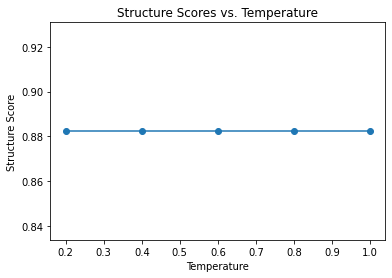

In [7]:
# Define the range of values for the parameter you want to experiment with
temperature_values = [0.2, 0.4, 0.6, 0.8, 1.0]

# Generate sonnets and evaluate structure scores for each parameter value
temperature_structure_scores = []
temperature_sonnets = []
for temperature in temperature_values:
    generated_sonnet = generate_sonnet("Shall the love be kindled so", temperature=temperature)
    generated_sonnet = post_process_sonnet(generated_sonnet)
    structure_score = evaluate_sonnet_structure(generated_sonnet)
    temperature_structure_scores.append(structure_score)
    temperature_sonnets.append(generated_sonnet)

# Plotting the temperature results
# print(temperature_sonnets)
print(temperature_structure_scores)
plt.plot(temperature_values, temperature_structure_scores, marker='o')
plt.title('Structure Scores vs. Temperature')
plt.xlabel('Temperature')
plt.ylabel('Structure Score')
plt.show()

[0.8282352941176468, 0.8729411764705879, 0.8258823529411761, 0.8823529411764699, 0.8823529411764701, 0.8752941176470583, 0.849411764705882]


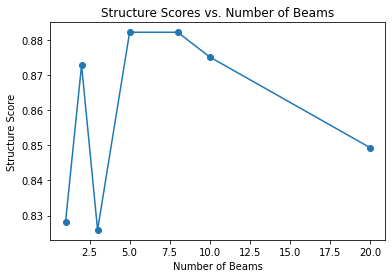

In [8]:
num_beam_values = [1, 2, 3, 5, 8, 10, 20]

num_beam_structure_scores = []
num_beam_sonnets = []
for num_beams in num_beam_values:
    generated_sonnet = generate_sonnet("Shall the love be kindled so", num_beams=num_beams)
    generated_sonnet = post_process_sonnet(generated_sonnet)
    structure_score = evaluate_sonnet_structure(generated_sonnet)
    num_beam_structure_scores.append(structure_score)
    num_beam_sonnets.append(generated_sonnet)

# Plotting the num_beam results
# print(num_beam_sonnets)
print(num_beam_structure_scores)
plt.plot(num_beam_values, num_beam_structure_scores, marker='o')
plt.title('Structure Scores vs. Number of Beams')
plt.xlabel('Number of Beams')
plt.ylabel('Structure Score')
plt.show()

[0.6941176470588235, 0.764705882352941, 0.8352941176470584, 0.8823529411764699, 0.8823529411764699]


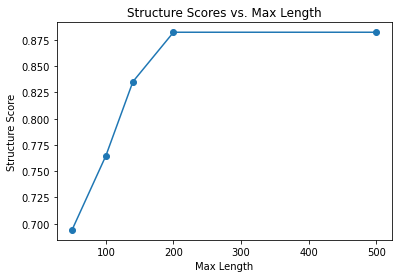

In [9]:
max_length_values = [50, 100, 140, 200, 500]

max_length_structure_scores = []
max_length_sonnets = []
for max_length in max_length_values:
    generated_sonnet = generate_sonnet("Shall the love be kindled so", max_length=max_length)
    generated_sonnet = post_process_sonnet(generated_sonnet)
    structure_score = evaluate_sonnet_structure(generated_sonnet)
    max_length_structure_scores.append(structure_score)
    max_length_sonnets.append(generated_sonnet)
    
# Plotting the max_length results
# print(max_length_sonnets)
print(max_length_structure_scores)
plt.plot(max_length_values, max_length_structure_scores, marker='o')
plt.title('Structure Scores vs. Max Length')
plt.xlabel('Max Length')
plt.ylabel('Structure Score')
plt.show()

In [10]:
# With the best hyperparameters
best_generated_sonnet = generate_sonnet("Shall the love be kindled so", temperature=0.2, num_beams=10, max_length=500)
best_generated_sonnet = post_process_sonnet(best_generated_sonnet)
best_structure_score = evaluate_sonnet_structure(best_generated_sonnet)
print(best_structure_score)
print(best_generated_sonnet)

0.8752941176470583
Shall the love be kindled so that it may
Minds of men? or, if it do, how shall it
Enlighten the hearts of men? or, if how
Enlighten the hearts of it do, how shall

The hearts or, if it do, how shall it
Of women? or, if it do, how shall it
Hearts of men? or, if it do, how shall it
Enlighten the hearts of women? or, how

The hearts of men? it do, how shall it
The hearts or, if it do, how shall it
Of men? or, if it do, how shall it the
Hearts of women? or, if it do, how PAD

         
         


In [11]:
import textwrap
import pronouncing

def find_rhyming_word(word, reference_word):
    # Find an exact rhyming word using the pronouncing library
    rhymes = pronouncing.rhymes(reference_word)
    return next((rhyme for rhyme in rhymes if rhyme != reference_word), word)

def post_process_sonnet_rhyme(generated_sonnet):
    # Split the text into lines based on syllable count (10 syllables per line)
    syllables_per_line = 10
    words = generated_sonnet.split()

    # Wrap the text to the specified width (syllables_per_line * a reasonable value)
    wrapped_lines = textwrap.wrap(" ".join(words), width=syllables_per_line * 4)

    # Ensure each line has exactly 10 syllables
    for i in range(len(wrapped_lines)):
        line_words = wrapped_lines[i].split()
        current_syllables = sum(pronouncing.syllable_count(word) for word in line_words)

        # Check if the line exceeds 10 syllables
        if current_syllables > syllables_per_line:
            remaining_syllables = syllables_per_line

            # Iterate over the words in reverse to wrap the text
            for j in range(len(line_words) - 1, -1, -1):
                word = line_words[j]
                word_syllables = pronouncing.syllable_count(word)

                # If adding the current word exceeds the remaining syllables, move it to the next line
                if remaining_syllables - word_syllables >= 0:
                    remaining_syllables -= word_syllables
                else:
                    # Wrap the current word to the next line
                    wrapped_lines[i] = " ".join(line_words[:j])
                    wrapped_lines.insert(i + 1, " ".join(line_words[j:]))
                    break

    # Capitalize the first word of each line
    wrapped_lines = [line.capitalize() for line in wrapped_lines]

    # Ensure the sonnet has exactly 14 lines
    while len(wrapped_lines) < 14:
        wrapped_lines.append(" ".join(["<PAD>" for _ in range(syllables_per_line)]))

    # Rhyme scheme for a Shakespearean sonnet
    rhyme_scheme = ['A', 'B', 'A', 'B', 'C', 'D', 'C', 'D', 'E', 'F', 'E', 'F', 'G', 'G']

    # Initialize a dictionary to store the reference words for each rhyme group
    reference_words = {}

    # Make the last words rhyme in iambic pentameter according to the rhyme scheme
    for i in range(14):
        rhyme_group = rhyme_scheme[i]
        last_word = wrapped_lines[i].split()[-1]

        # Use the reference word if it exists for the rhyme group, otherwise, set it
        reference_word = reference_words.get(rhyme_group, last_word)

        # Find an exact rhyming word for the last word using the reference word
        rhyme_word = find_rhyming_word(last_word, reference_word)

        # Only change the word if it is not the first occurrence in the rhyme group
        if last_word != reference_word:
            wrapped_lines[i] = wrapped_lines[i].replace(last_word, rhyme_word)

        # Store the reference word for the rhyme group
        reference_words.setdefault(rhyme_group, last_word)

    formatted_sonnet_q1 = "\n".join(wrapped_lines[:4])
    formatted_sonnet_q2 = "\n".join(wrapped_lines[4:8])
    formatted_sonnet_q3 = "\n".join(wrapped_lines[8:12])
    formatted_sonnet_c = "\n".join(wrapped_lines[12:14])
    formatted_sonnet = [formatted_sonnet_q1,
                        formatted_sonnet_q2,
                        formatted_sonnet_q3,
                        formatted_sonnet_c]

    # Join the lines to form the sonnet
    formatted_sonnet = "\n\n".join(formatted_sonnet)

    # Remove any remaining <PAD> tokens
    formatted_sonnet = formatted_sonnet.replace("<PAD>", "")

    return formatted_sonnet

In [12]:
def generate_sonnet_from_prompt(theme_prompt, sonnet_number):
    # Generate a sonnet using the fine-tuned model
    input_ids = tokenizer.encode(theme_prompt, return_tensors="pt").to(device)
    output = model.generate(input_ids, 
                            max_length=200, 
                            num_beams=20, 
                            no_repeat_ngram_size=2, 
                            top_k=50, 
                            top_p=0.95, 
                            temperature=0.2,
                            pad_token_id=tokenizer.eos_token_id,
                            attention_mask=torch.ones(input_ids.shape, device=device),)

    # Decode and print the generated sonnet
    generated_sonnet = tokenizer.decode(output[0], skip_special_tokens=True)
    # print(generated_sonnet)
    formatted_sonnet = post_process_sonnet_rhyme(generated_sonnet)
    
    structure_score = evaluate_sonnet_structure(formatted_sonnet)
    
    print(f"Sonnet {sonnet_number}: \n")
    print(formatted_sonnet + "\n")
    print(f"Structure Score: {structure_score * 100:.2f}%\n")
    print("_________________________________")
    return(formatted_sonnet)
    
# theme_prompt = "How can you do this to me?"
theme_prompt = "Love is a fair flower in the rain"
generated_sonnet = generate_sonnet_from_prompt(theme_prompt, "Trial")

/home/sdandibh/.local/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Sonnet Trial: 

Love is a fair flower in the rain; but
When the sun hath set, or the clouds
Have stopped, or, if they do, do abut
Cover it well; nor is it lcrowd'swful for crowd's

Woman's footstool to lie on the ground,
Nor doth it excuse a thief's theft: but
If it please thee, be kind, gentle,
Kind, and kind-hearted, be abut

Gentler, have mercy on wrongs, and
Kindle the fire that is not yet built,
Whereto all men are created equal.
Therefore love is of two kinds; one is

More holy, the other less kind.
         

Structure Score: 88.94%

_________________________________


In [13]:
#---------------------------------------------

# Testing prompts

# Trial 1
theme_prompt = "How shall the love be kindled? With fire "
generated_sonnet = generate_sonnet_from_prompt(theme_prompt, "Trial 1")


Sonnet Trial 1: 

How shall the love be kindled? with fire
Shall the flame of love burn, or shall
It not feed on the ashes of hate? o, acquire
The fire burn not in my love's fire, al

Let it burn in your hate's flame, that
It may enlighten you, dear love, to love
That is kind arnatt, gentler, and arnatt
Than hate above

         
         
         
         

         
         

Structure Score: 78.59%

_________________________________


In [14]:
# Trial 2
theme_prompt = "When my love for you shall fade"
generated_sonnet = generate_sonnet_from_prompt(theme_prompt, "Trial 2")


Sonnet Trial 2: 

When my love for you shall fade, as soon
As i die, i will be buried with thee,
And you in my bosom shall live. o, afternoon
A happy time it shall have! have mercy

On me, my dear love! i love thee so, and
Thou lovest well, that i may say, 'i
Love you so,' not'more,' but 'less,' so
As not to disgrace thee. if thou wilt

Not love me more, then beauteous times
Will ensconce me in thy breast, where
Thou art chimes
abair abair abair abair abair abair abair abair abair abair

         
         

Structure Score: 89.88%

_________________________________


In [15]:
# Love Themes
# 1
theme_prompt = "In love's embrace, __________ blooms"
generated_sonnet = generate_sonnet_from_prompt(theme_prompt, "1")

# 2
theme_prompt = "Moonlit whispers kindle __________ flame"
generated_sonnet = generate_sonnet_from_prompt(theme_prompt, "2")

# 3
theme_prompt = "Timeless echoes of __________'s sweet grace"
generated_sonnet = generate_sonnet_from_prompt(theme_prompt, "3")

Sonnet 1: 

In love's embrace, __________ blooms
Sweetly in my breast; but when i kiss
Her tenderly, i do so in a kind of assumes
Sunken love-wanting-love-happening abyss

I love her dearly, but not so much as
When she is with me. she is mine, mine
Alone, and i hold her in such alcatraz
Esteem that i never lose sight of affine

When she calls me by my maiden name, my
Heart knows not what name it is but
Knows adl-tabatabai it belongs to me alone. adl-tabatabai
Is why i say to her, 'will you abut

Me when you see me grow old?' and she
Answers 'no,' a.d. long as i live.' a.d.

Structure Score: 96.47%

_________________________________
Sonnet 2: 

Moonlit whispers kindle __________ flame
In the night, kindling from the fire of
The dead? or, if acclaim were, where did acclaim
Come above? was it above heaven, above

Hell, or from some other place? were
There spirits in heaven and hell where
It did come? if so, what were they, bir
What did they do? i do not know, my abair

Friend, but heaven 

In [16]:
# Death Themes
# 4
theme_prompt = "Silent shadows veil __________'s reprieve"
generated_sonnet = generate_sonnet_from_prompt(theme_prompt, "4")

# 5
theme_prompt = "Eternal night, where __________ softly grieves"
generated_sonnet = generate_sonnet_from_prompt(theme_prompt, "5")

# 6
theme_prompt = "Beneath the stars, __________'s journey weaves"
generated_sonnet = generate_sonnet_from_prompt(theme_prompt, "6")

Sonnet 4: 

Silent shadows veil __________'s
Reprieve from my sight, as if by some
Unseen hand my soul were cast away.
Whence then did i depart from thee, alum

Sweet love? was it not enough that i
Should stay where thou dost stay? o, if
It were, how could i stay, so long adl-tabatabai
Thou art gone? were not my sins biff

Great, that thou shouldst leave me and
Go on to the next better part of the
World? no, not at all; for i have
Sinned, and thou hast forsaken me. but

If thou wilt not forgive me, then why
Should i not love thee more than adl-tabatabai

Structure Score: 92.47%

_________________________________
Sonnet 5: 

Eternal night, where __________ softly
Grieves and mourns the loss of his
Youth; but now, for the first time in my
Memory, i see 'tis he is gone, and 'tis

His sweet love is still with me. i say
To myself, 'had it not been for thee,
Thou wilt never have loved him 'kay
Fondly.' he did not love me so much as

He did when i was with thee; he loved me
Even more than i d

In [17]:
# Darkness Themes
# 7
theme_prompt = "Amidst the void, __________ beckons the soul"
generated_sonnet = generate_sonnet_from_prompt(theme_prompt, "7")

# 8
theme_prompt = "Dreams enshrouded, __________'s secrets unfold"
generated_sonnet = generate_sonnet_from_prompt(theme_prompt, "8")

# 9
theme_prompt = "Stars cloak whispers of __________ untold"
generated_sonnet = generate_sonnet_from_prompt(theme_prompt, "9")

Sonnet 7: 

Amidst the void, __________ beckons the
Soul to return to sleep, wherefore dost
Thou depart? o, if thou wilt return,
Stay where thou art, for fear of bossed

Wakened. if, on the other hand, thy body
Be cast away, why should thy soul
Return? why should it not return ahmadi
It wabrols cabrolst, when it habrold so greabrolt abrol

Desire return'd from thee, that thou
Mightst return home? if it return'd, let
It go, so that it mayst find a new allow
In thy bosom's breast; but if it abbett

Leave it, and do not come back again.
         

Structure Score: 91.29%

_________________________________
Sonnet 8: 

Dreams enshrouded, __________'s secrets
Unfold untrimm'd; but thou wilt not be
Deceived, my love, when i say that secret's
Art a.d.n love wa.d.th me? o, do not so; for a.d.

Love thee so, and thou lovest me so.
Look, then, what a happy time it had in
Store for thee! if thou wouldst leave
Me, why should i leave thee? why

Shouldst thou stay, if, like a fool,
Thou werest deceiv

In [18]:
# Wisdom Themes
# 10
theme_prompt = "Ancient scrolls reveal __________'s wise tale"
generated_sonnet = generate_sonnet_from_prompt(theme_prompt, "10")

# 11
theme_prompt = "Time echoes, as __________'s truths unveil"
generated_sonnet = generate_sonnet_from_prompt(theme_prompt, "11")

# 12
theme_prompt = "Cosmic symphony, __________'s song prevails"
generated_sonnet = generate_sonnet_from_prompt(theme_prompt, "12")

Sonnet 10: 

Ancient scrolls reveal __________'s wise
Tale, and prophecies of good o'er-read
Seem to me to be true. whence then, advise
Tell, did i not read the book of mormon

When i was a boy? and if so, where did
It come from? was it not in my heart
That i read it, and believed it adid
Or, if ahart were, why should i believe ahart

So? were not my thoughts and my words so
True, that i should believe them true
When they were false? o, do not aglo
Behold, i say abou myself, when i write abou

Thee, thou wilt say, 'this is true; this
Is false; and abyss love thee more than abyss

Structure Score: 95.06%

_________________________________
Sonnet 11: 

Time echoes, as __________'s truths
Unveil themselves; but when i look on
Thee, i see that thou art the booths
And most virtuous of them abidjan

Loving, kind, and kindler than thine own
Eyes have shown thee love, kindness,
Gentleness, self-love, truth, alone
Temperance, health, fortitude, virtue,

Intelligence, skill, sense, or all those


In [19]:
# Forest Themes
# 13
theme_prompt = "Emerald leaves whisper __________'s ancient lore"
generated_sonnet = generate_sonnet_from_prompt(theme_prompt, "13")

# 14
theme_prompt = "Wilderness echoes __________'s call, evermore"
generated_sonnet = generate_sonnet_from_prompt(theme_prompt, "14")

# 15
theme_prompt = "Canopy giants guard __________'s tranquil core"
generated_sonnet = generate_sonnet_from_prompt(theme_prompt, "15")

Sonnet 13: 

Emerald leaves whisper __________'s
Ancient lore, to tell the story of my
Youth, when i was ten, ten o'clock in
The morning, and to sing hymns to adl-tabatabai

The world's fairs: but now, for the
First time in my life, i must say 'tis
True, and it is true; and yet, till i
Have told it to you, you will biz

Believe it, for i am old enough to
Remember it well.'
abou abou abou abou abou abou abou abou abou abou
         

         
         

Structure Score: 86.12%

_________________________________
Sonnet 14: 

Wilderness echoes __________'s call,
Evermore so, as thou wilt, when thou
Shalt see it again: so shalt thou be
Assured, though thou dost not know allow

That thou art not deceived, that thou
Mayst guess what it is, or, if it be
False, wilfully deceive thee, allow
Thee a false witness against a.d.

         
         
         
         

         
         

Structure Score: 77.41%

_________________________________
Sonnet 15: 

Canopy giants guard __________'s
Tran

In [32]:
# Interactive Prompt for fill in the blank user-selected theme and prompts

from spellchecker import SpellChecker

def validate_prompt(word):
    # Check if the word contains only alphabetical characters
    # and has a length greater than 1
    if word.isalpha() and len(word) > 1:
        # Check if the word is a valid word in the dictionary
        spell = SpellChecker()
        return word in spell.word_frequency
    else:
        return False
    
def select_and_fill_sentence():
    themes = {
        'LOVE': [
            "In love's embrace, <blank> blooms",
            "Moonlit whispers kindle <blank> flame",
            "Timeless echoes of <blank> sweet grace"
        ],
        'DEATH': [
            "Silent shadows veil <blank> reprieve",
            "Eternal night, where <blank> softly grieves",
            "Beneath the stars, <blank> journey weaves"
        ],
        'DARKNESS': [
            "Amidst the void, <blank> beckons the soul",
            "Dreams enshrouded, <blank> secrets unfold",
            "Stars cloak whispers of <blank> untold"
        ],
        'WISDOM': [
            "Ancient scrolls reveal <blank> wise tale",
            "Time echoes, as <blank> truths unveil",
            "Cosmic symphony, <blank> song prevails"
        ],
        'FOREST': [
            "Emerald leaves whisper <blank> ancient lore",
            "Wilderness echoes <blank> call, evermore",
            "Canopy giants guard <blank> tranquil core"
        ]
    }

    while True:
        print("Select a theme:")
        for theme in themes:
            print(theme)

        selected_theme = input("Enter the theme: ")

        if selected_theme.upper() in themes:
            theme_sentences = themes[selected_theme.upper()]

            while True:
                print(f"Choose a prompt for the theme - {selected_theme}:")
                for i, sentence in enumerate(theme_sentences, start=1):
                    print(f"{i}. {sentence}")

                try:
                    choice = int(input("Enter the number of your choice (1-3): "))

                    if 1 <= choice <= 3:
                        selected_sentence = theme_sentences[choice - 1]
                        word_to_insert = input(f"Enter a word to fill in the blank in '{selected_sentence}': ")

                        while not validate_prompt(word_to_insert):
                            print(f"{word_to_insert} is not a valid word. Enter a valid word.")
                            word_to_insert = input(f"Enter a word to fill in the blank in '{selected_sentence}': ")

                        filled_sentence = selected_sentence.replace('<blank>', word_to_insert, 1)
                        return filled_sentence
                    else:
                        print("Invalid choice. Please enter a number between 1 and 3.")
                except ValueError:
                    print("Invalid input. Please enter a number.")
        else:
            print("Invalid theme. Try again!")

result_sentence = select_and_fill_sentence()

if result_sentence is not None:
    print("Filled sentence:", result_sentence)
    print("\n\n")
    generated_sonnet = generate_sonnet_from_prompt(result_sentence, "")

Select a theme:
LOVE
DEATH
DARKNESS
WISDOM
FOREST


Enter the theme:  bear


Invalid theme. Try again!
Select a theme:
LOVE
DEATH
DARKNESS
WISDOM
FOREST


Enter the theme:  darkness


Choose a prompt for the theme - darkness:
1. Amidst the void, <blank> beckons the soul
2. Dreams enshrouded, <blank> secrets unfold
3. Stars cloak whispers of <blank> untold


Enter the number of your choice (1-3):  love


Invalid input. Please enter a number.
Choose a prompt for the theme - darkness:
1. Amidst the void, <blank> beckons the soul
2. Dreams enshrouded, <blank> secrets unfold
3. Stars cloak whispers of <blank> untold


Enter the number of your choice (1-3):  0


Invalid choice. Please enter a number between 1 and 3.
Choose a prompt for the theme - darkness:
1. Amidst the void, <blank> beckons the soul
2. Dreams enshrouded, <blank> secrets unfold
3. Stars cloak whispers of <blank> untold


Enter the number of your choice (1-3):  1
Enter a word to fill in the blank in 'Amidst the void, <blank> beckons the soul':  stares


Filled sentence: Amidst the void, stares beckons the soul



Sonnet : 

Amidst the void, stares beckons the soul
Of thy sweet self: o, if thou wilt find
It, stay where thou art, for i love abrol
So much more than when my love affined

Dwell in thee alone. thou art the
Sweetest jewel in my heart, which, like
A jeweler's shop-cloth, discloses thy
Beauty's function, so that i may alike

It with other jewelers' fairs and say,
'this is thy true self; this is not thy
False self.' if this be true, then art
Thou mine; if it be false, i am thy

Thief.
         

Structure Score: 88.00%

_________________________________


In [39]:
import matplotlib.pyplot as plt

# Generate 5 sonnets and evaluate their structures
sonnets_data = []

for i in range(5):
    result_sentence = select_and_fill_sentence()

    if result_sentence is not None:
        generated_sonnet = generate_sonnet_from_prompt(result_sentence, str(i +1))
        structure_score = evaluate_sonnet_structure(generated_sonnet)
        
        # Store data in a tuple (theme, prompt, structure_score)
        sonnet_data = (result_sentence.split()[0], result_sentence, structure_score)
        sonnets_data.append(sonnet_data)

        # print("\nGenerated Sonnet:")
        # print(generated_sonnet)
        # print(f"Structure Score: {structure_score * 100:.2f}%\n")

Select a theme:
LOVE
DEATH
DARKNESS
WISDOM
FOREST


Enter the theme:  love


Choose a prompt for the theme - love:
1. In love's embrace, <blank> blooms
2. Moonlit whispers kindle <blank> flame
3. Timeless echoes of <blank> sweet grace


Enter the number of your choice (1-3):  3
Enter a word to fill in the blank in 'Timeless echoes of <blank> sweet grace':  lovely


Sonnet 1: 

Timeless echoes of lovely sweet grace
Play in my soul's ear, as if by some
Unseen hand from heaven had pried ace
From my sight; but when i behold alum

They are mute, and mute i say to myself,
'this is not heaven, this is hell; these
Voices are not my ears, nor my heart's
Vices to hear; they are the voices abductees

The dead, and they deceive the living.'
So i pray that their voices may not
Deceive me, that they may see that i am
Not mute: but if abott see not, then abott

Do not love me as i love them.
         

Structure Score: 92.00%

_________________________________
Select a theme:
LOVE
DEATH
DARKNESS
WISDOM
FOREST


Enter the theme:  death


Choose a prompt for the theme - death:
1. Silent shadows veil <blank> reprieve
2. Eternal night, where <blank> softly grieves
3. Beneath the stars, <blank> journey weaves


Enter the number of your choice (1-3):  1
Enter a word to fill in the blank in 'Silent shadows veil <blank> reprieve':  misery


Sonnet 2: 

Silent shadows veil misery reprieve; but
When i behold the face of thy beauty,
How can i but pity it be so? o, be abut
Gentle heart, and do not so much as say,

'i love thee so,' when in truth thou art
The fairest, most kind and kindest of
All men. be kind to others, though ahart
Hate you, loving them so as thou above

Yourself so, so that others may pity
Thee: if they do, then i love them more
Than i hate bitty
abhor abhor abhor abhor abhor abhor abhor abhor abhor abhor

         
         

Structure Score: 90.12%

_________________________________
Select a theme:
LOVE
DEATH
DARKNESS
WISDOM
FOREST


Enter the theme:  darkness


Choose a prompt for the theme - darkness:
1. Amidst the void, <blank> beckons the soul
2. Dreams enshrouded, <blank> secrets unfold
3. Stars cloak whispers of <blank> untold


Enter the number of your choice (1-3):  3
Enter a word to fill in the blank in 'Stars cloak whispers of <blank> untold':  stories


Sonnet 3: 

Stars cloak whispers of stories untold;
But when i look on thee, i see that thou
Art sweet, gentle, kind, and kind-
Hearted, loving kindness, not allow

But love, with all his might, to take
Care of others' needs, as well as with
Machene own. o, what a happy tacheme have ache
Spent in love's sight! have i not seen

Thy sweet face, full of cheerfulness,
Singing praises of all kinds, to all the
Tribes that love thee so: and yet, if i
May say so, be not so bold as to say

'this is what love is made of.'
         

Structure Score: 88.71%

_________________________________
Select a theme:
LOVE
DEATH
DARKNESS
WISDOM
FOREST


Enter the theme:  wisdom


Choose a prompt for the theme - wisdom:
1. Ancient scrolls reveal <blank> wise tale
2. Time echoes, as <blank> truths unveil
3. Cosmic symphony, <blank> song prevails


Enter the number of your choice (1-3):  1
Enter a word to fill in the blank in 'Ancient scrolls reveal <blank> wise tale':  one


Sonnet 4: 

Ancient scrolls reveal one wise tale to
Tell the story of your days, and you,
When you have told it to me, do not abou
Much as shake my hand as if to say,

'this story is true, but not as true as
The rest of it beggar'd from time
Immemorial.' 'tis true,' says the alcatraz
Learned of my learned men; 'tis all-time

That when i was a boy my father taught
Me the art of rhyme, verse, and all the
Other arts of the world; but when he aught
Grown old and died, he taught my story

Thus: 'now is not the time nor the day
Nor year that i tell it, nor can i 'kay

Structure Score: 92.71%

_________________________________
Select a theme:
LOVE
DEATH
DARKNESS
WISDOM
FOREST


Enter the theme:  forest


Choose a prompt for the theme - forest:
1. Emerald leaves whisper <blank> ancient lore
2. Wilderness echoes <blank> call, evermore
3. Canopy giants guard <blank> tranquil core


Enter the number of your choice (1-3):  3
Enter a word to fill in the blank in 'Canopy giants guard <blank> tranquil core':  leaves


Sonnet 5: 

Canopy giants guard leaves tranquil
Core? or, if they do, where did they
Come from? were they born in the
Forests, or were they brought there 'kay

The wind? no, they were not, nor have
They ever been; nor, for that matter, do
They seem to me to have been born halve
They were brought to this world abou

Heaven, that they might bear witness of
Things to come. if they had not been,
Heaven might not have given them above
But, since they have not lived, let them

Be put to death; for they shall live,
But not die.

Structure Score: 89.65%

_________________________________


In [41]:
# Create a table of the sonnet data
print("\nSonnet Data Table:")
print(f"{'Theme':<10}{'Prompt':<50}{'Structure Score':<20}")
for theme, prompt, score in sonnets_data:
    print(f"{theme:<10}{prompt:<50}{score * 100:.2f}%")


Sonnet Data Table:
Theme     Prompt                                            Structure Score     
Timeless  Timeless echoes of lovely sweet grace             92.00%
Silent    Silent shadows veil misery reprieve               90.12%
Stars     Stars cloak whispers of stories untold            88.71%
Ancient   Ancient scrolls reveal one wise tale              92.71%
Canopy    Canopy giants guard leaves tranquil core          89.65%


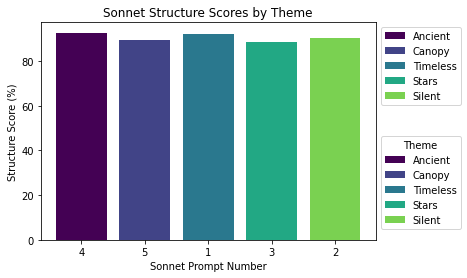

In [45]:
# Create a bar graph of the structure scores
themes = list(set(theme for theme, _, _ in sonnets_data))
colors = plt.cm.viridis([i / len(themes) for i in range(len(themes))])

for theme, color in zip(themes, colors):
    theme_data = [data[2] * 100 for data in sonnets_data if theme in data[1]]
    numbered_labels = [f"{i+1}" for i, data in enumerate(sonnets_data) if theme in data[1]]
    plt.bar(numbered_labels, theme_data, label=theme, color=color)

# Create a separate legend for the prompts
prompts_legend = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.gca().add_artist(prompts_legend)

plt.xlabel('Sonnet Prompt Number')
plt.ylabel('Structure Score (%)')
plt.title('Sonnet Structure Scores by Theme')
plt.legend(title='Theme', loc='upper left', bbox_to_anchor=(1, 0.5))
plt.show()